In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import tensorflow as tf
import random
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image


from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
DIR_PATH = '/content/gdrive/MyDrive/dog_class'

image_dir = Path(DIR_PATH)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

df = pd.concat([filepaths, labels], axis=1)

In [4]:
df

,Filepath,Label
0,/content/gdrive/MyDrive/dog_class/Poodle/Poodl...,Poodle
1,/content/gdrive/MyDrive/dog_class/Poodle/Poodl...,Poodle
2,/content/gdrive/MyDrive/dog_class/Poodle/Poodl...,Poodle
3,/content/gdrive/MyDrive/dog_class/Poodle/Poodl...,Poodle
4,/content/gdrive/MyDrive/dog_class/Poodle/Poodl...,Poodle
...,...,...
962,/content/gdrive/MyDrive/dog_class/Yorkshire_Te...,Yorkshire_Terrier
963,/content/gdrive/MyDrive/dog_class/Yorkshire_Te...,Yorkshire_Terrier
964,/content/gdrive/MyDrive/dog_class/Yorkshire_Te...,Yorkshire_Terrier
965,/content/gdrive/MyDrive/dog_class/Yorkshire_Te...,Yorkshire_Terrier


In [5]:
df['Label'].isnull().sum()

0

In [6]:
df.describe()

,Filepath,Label
count,967,967
unique,967,10
top,/content/gdrive/MyDrive/dog_class/Poodle/Poodl...,Poodle
freq,1,100


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  967 non-null    object
 1   Label     967 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [8]:
df['Label'].value_counts()

Label
Poodle                100
Beagle                100
Bulldog               100
Boxer                 100
Yorkshire_Terrier     100
German_Shepherd        96
Dachshund              96
Labrador_Retriever     95
Golden_Retriever       91
Rottweiler             89
Name: count, dtype: int64

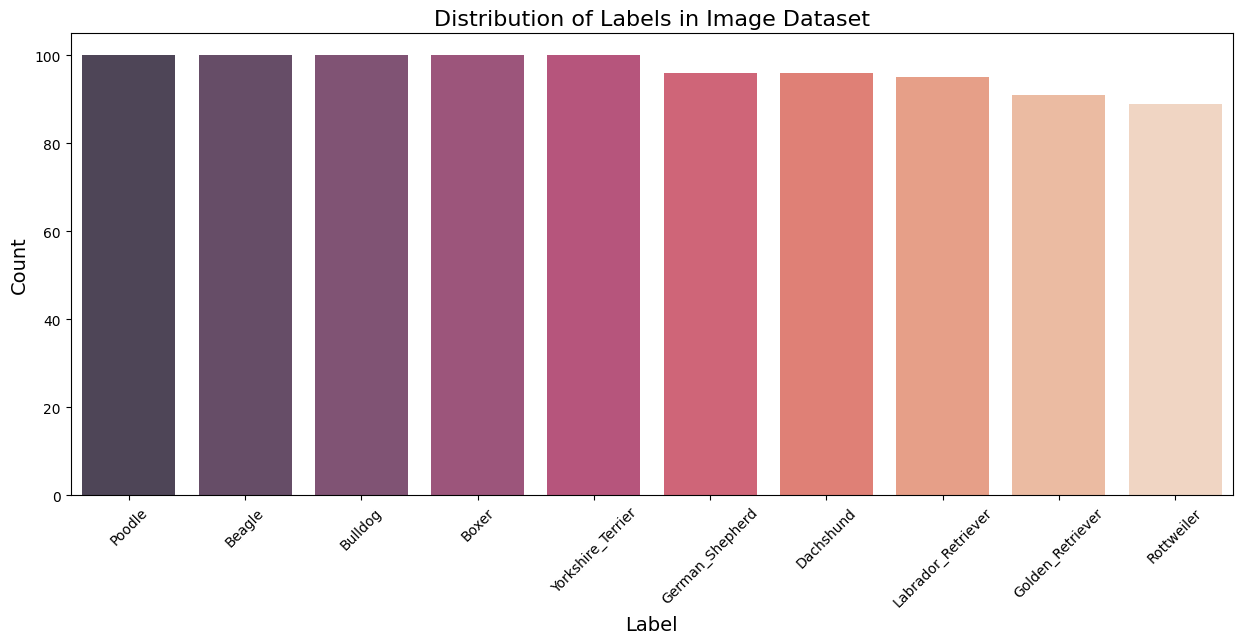

In [10]:
label_counts = df['Label'].value_counts()

plt.figure(figsize=(15, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, hue=label_counts.index, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

plt.show()

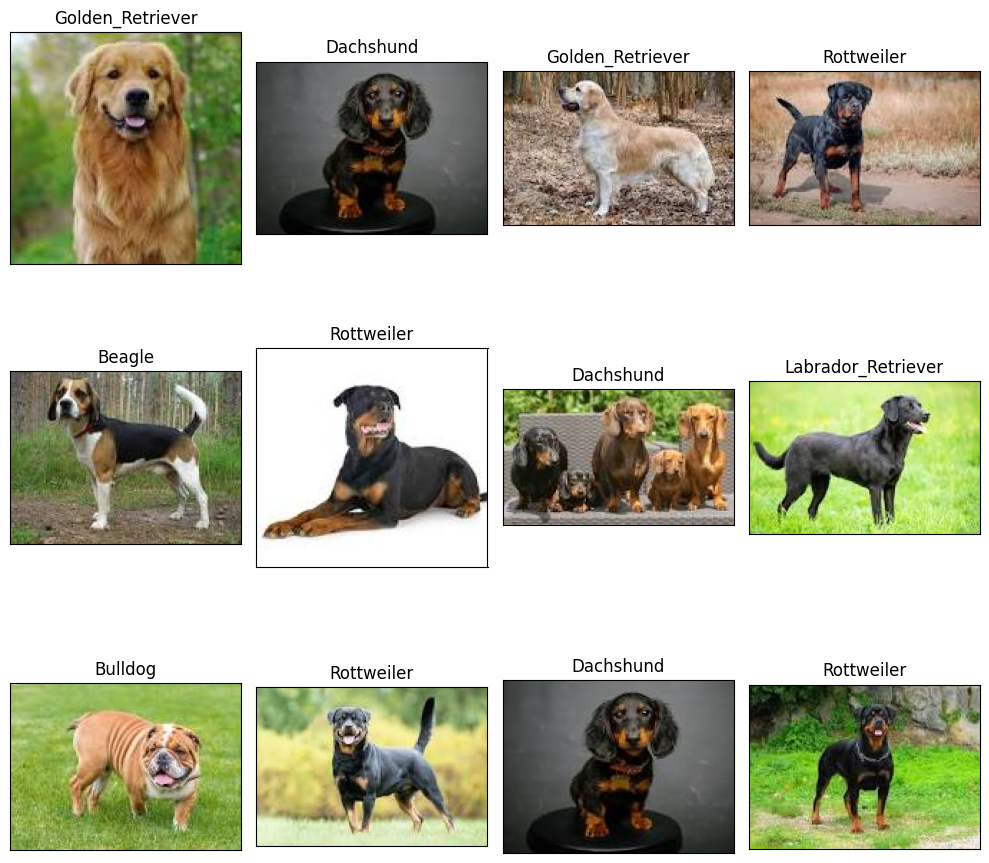

In [12]:
random_index = np.random.randint(0, len(df), 12)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[random_index[i]]))
    ax.set_title(df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['Filepath'], df['Label'], test_size=0.2, shuffle=True, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((773,), (194,), (773,), (194,))

In [13]:
set(df['Label'])

{'Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier'}

In [16]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

y_train_encoded.shape, y_test_encoded.shape

((773,), (194,))

In [19]:
categories = len(set(df['Label']))

categories

10

In [20]:
y_train_encoded = to_categorical(y_train_encoded, categories)
y_test_encoded = to_categorical(y_test_encoded, categories)

X_train.shape, X_test.shape, y_train_encoded.shape, y_test_encoded.shape

((773,), (194,), (773, 10), (194, 10))

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

df_train = pd.DataFrame({
    'Filepath': X_train,
    'Label': y_train
})

df_test = pd.DataFrame({
    'Filepath': X_test,
    'Label': y_test
})

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='train_images',
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='test_images',
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 773 validated image filenames belonging to 10 classes.
Found 194 validated image filenames belonging to 10 classes.


In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(categories, activation='softmax')
])

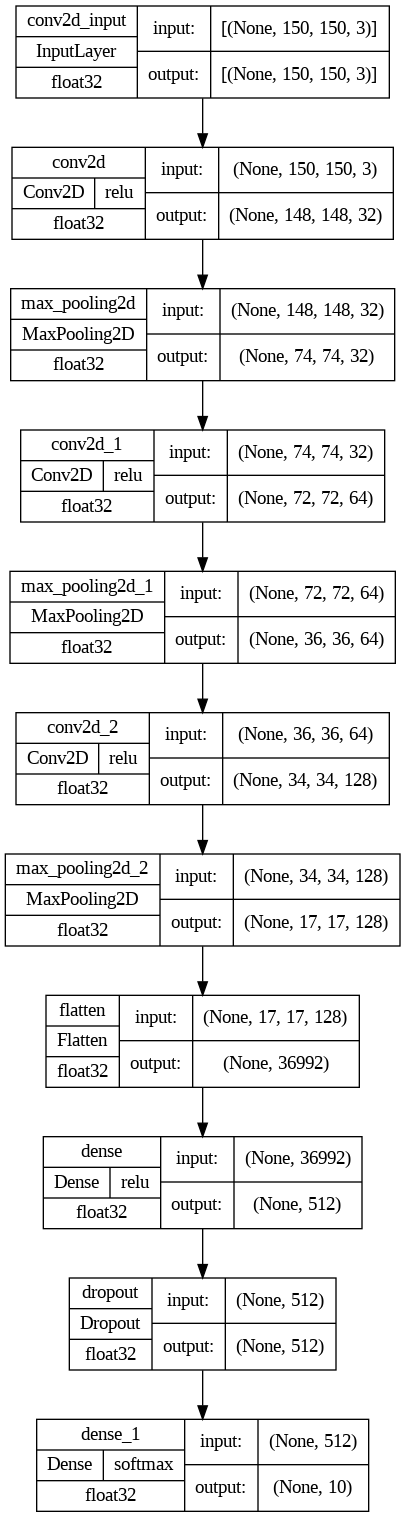

In [30]:
plot_model(model, show_dtype=True, show_layer_activations=True, show_shapes=True)

In [31]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
24/24 [==============================] - 254s 11s/step - loss: 2.4178 - accuracy: 0.1606 - val_loss: 2.0981 - val_accuracy: 0.2604
Epoch 2/5
24/24 [==============================] - 52s 2s/step - loss: 1.6439 - accuracy: 0.4480 - val_loss: 1.0535 - val_accuracy: 0.6927
Epoch 3/5
24/24 [==============================] - 52s 2s/step - loss: 0.6332 - accuracy: 0.8124 - val_loss: 0.2013 - val_accuracy: 0.9740
Epoch 4/5
24/24 [==============================] - 49s 2s/step - loss: 0.1728 - accuracy: 0.9487 - val_loss: 0.0741 - val_accuracy: 0.9792
Epoch 5/5
24/24 [==============================] - 52s 2s/step - loss: 0.0627 - accuracy: 0.9892 - val_loss: 0.0030 - val_accuracy: 1.0000


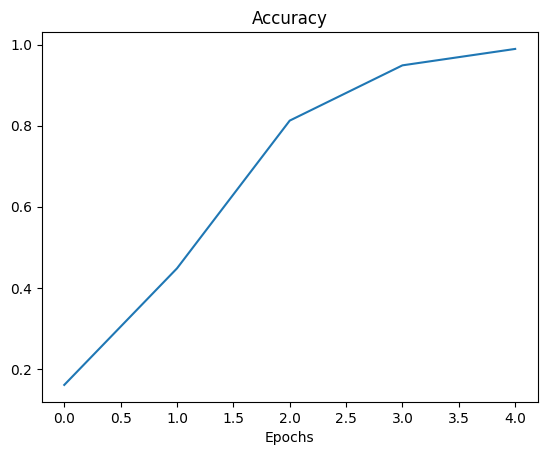

In [34]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

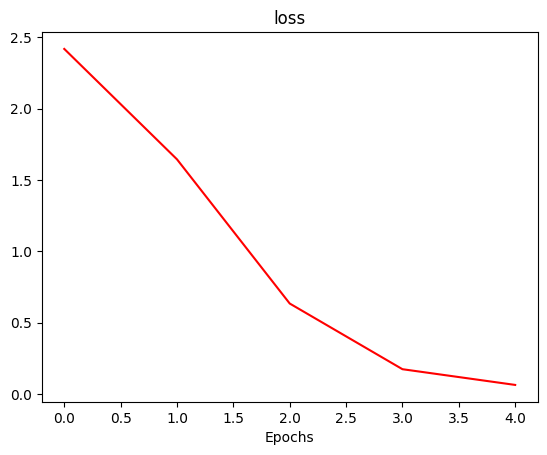

In [35]:
plt.plot(history.history['loss'], c='r')
plt.title('loss')
plt.xlabel('Epochs')

plt.show()

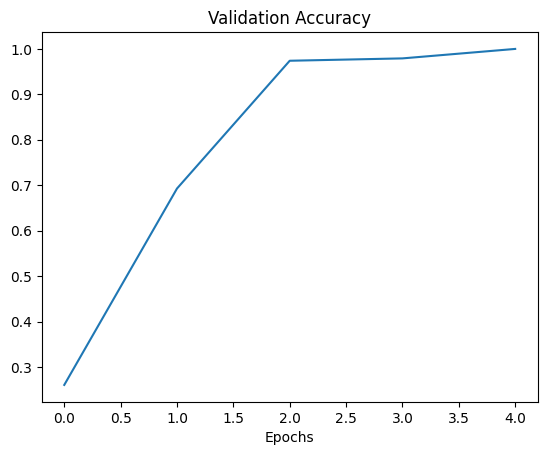

In [36]:
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')

plt.show()

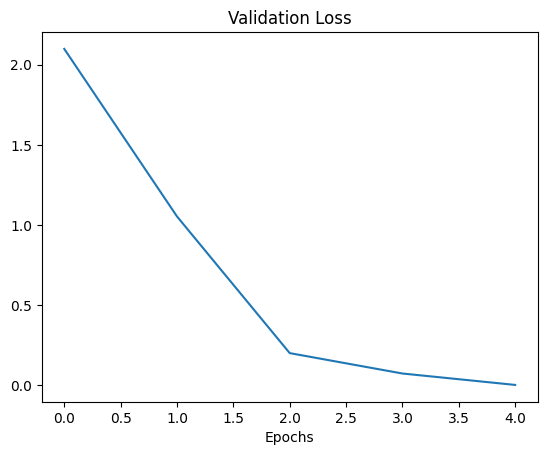

In [37]:
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')

plt.show()

In [38]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy} Test Loss: {loss}')

7/7 [==============================] - 4s 451ms/step - loss: 0.0030 - accuracy: 1.0000
Test accuracy: 1.0 Test Loss: 0.002975428244099021


In [39]:
model.save('dog_breed_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
def predict_random_image(model, generator, label_encoder):
    batch = next(generator)
    images, labels = batch

    idx = random.randint(0, len(images) - 1)

    plt.imshow(images[idx])
    actual_label = label_encoder.inverse_transform([np.argmax(labels[idx])])[0]
    plt.title(f'Actual: {actual_label}')
    plt.show()

    image = images[idx].reshape(1, 150, 150, 3)
    y_pred = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])

    print(f'Prediction probabilities: {y_pred}')
    print(f'Predicted class: {predicted_class[0]}')

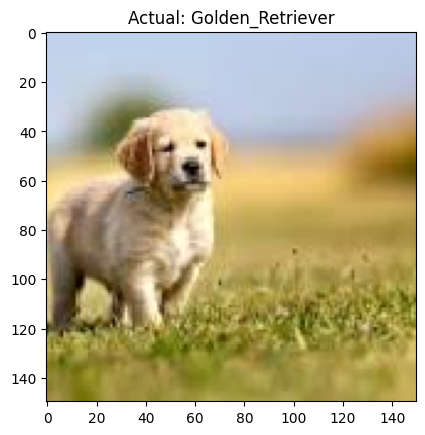

1/1 [==============================] - 0s 149ms/step
Prediction probabilities: [[9.4283536e-07 6.1360623e-08 7.3942651e-08 3.0957606e-06 5.9398621e-06
  9.9995160e-01 3.6802194e-05 1.0404837e-07 1.7109313e-08 1.2813440e-06]]
Predicted class: Golden_Retriever


In [44]:
model = load_model('dog_breed_classifier_model.h5')

predict_random_image(model, validation_generator, label_encoder)